Joint Shapley value calculations on the Boston housing dataset (Harrison and Rubinfeld, 1978, JEEM)

In [1]:
#import xgboost
import shap
import sklearn
import numpy as np
import pandas as pd
import random
from IPython.display import display, clear_output

import seaborn as sns
import matplotlib as mpl
import matplotlib.pyplot as plt
import copy
sns.set_theme(style="whitegrid")

EMPTY = frozenset()

# from joint_shapley import * # Where most of the JS code is 

In [2]:
k = 3

In [3]:
def get_powerset_to_k(
    features, 
    k,
    init=True,
):
    if init:
        features = [s if type(s) == frozenset else frozenset([s]) for s in features]
    if len(features) <= 1:
        yield features[0]
        yield frozenset()
    else:
        for item in get_powerset_to_k(features[1:], k, False):
            if len(item) <= k - 1:
                yield features[0].union(item)
            yield item
            
def get_powerset_to_k_ex_emptyset(seq, k):
    gen = get_powerset_to_k(seq, k)
    for item in gen:
        if item != frozenset():
            yield item

In [4]:
t = get_powerset_to_k(["a", "b", "c", "d"], 2)
list(t)

[frozenset({'c', 'd'}),
 frozenset({'b', 'd'}),
 frozenset({'a', 'd'}),
 frozenset({'d'}),
 frozenset({'b', 'c'}),
 frozenset({'a', 'c'}),
 frozenset({'c'}),
 frozenset({'a', 'b'}),
 frozenset({'b'}),
 frozenset({'a'}),
 frozenset()]

In [5]:
dataset_pathname = "boston"
X,y = shap.datasets.boston()
col_rename = {l: f"{l}" for l in X.columns}
X = X.rename(columns=col_rename)
y = y
x_labels = [f"{l}" for l in X.columns]
n = len(x_labels)
print(f"Dataset has {n} features and {len(y)} observations")

Dataset has 13 features and 506 observations


In [6]:
# Split train/test
np.random.seed(0)
test_train_split = np.random.uniform(0, 1, len(y)) <= .75
train_X = X[test_train_split]
train_y = y[test_train_split]
test_X = X[~test_train_split]
test_y = y[~test_train_split]

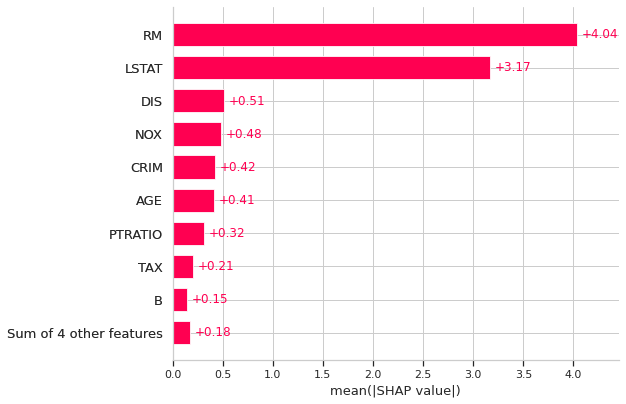

In [7]:
model = sklearn.ensemble.RandomForestRegressor(
    n_jobs=10, n_estimators=50,random_state=0
).fit(train_X, train_y)

y_predicted = model.predict(test_X)
explainer = shap.Explainer(model)
shap_values = explainer(test_X)
shap.plots.bar(shap_values)

In [8]:
n_features = frozenset(x_labels)

#### Define value function

In [9]:
coalitions_to_k = get_powerset_to_k(n_features, 2)

baseline = explainer(test_X).base_values

def value_function(cln_X):
#     full_X = test_X.copy()
#     full_X.loc[:, [col not in cln_X.columns for col in X.columns]] = \
#         full_X.mean(axis=0).loc[[col not in cln_X.columns for col in X.columns]].values.T
#     full_X.loc[:, cln_X.columns] = cln_X
    return model.predict(cln_X)# - baseline[0]

In [10]:
def get_coalition_arrivals(t_cln, x_labels):
    clns_arrived = []
    arrived_features = frozenset()
    all_features = frozenset(x_labels)
    clns_up_to_t, clns_up_to_incl_t = None, None
    while(len(arrived_features) < len(all_features)):
        to_arrive = all_features.difference(arrived_features)
        possible_next = list(get_powerset_to_k_ex_emptyset(to_arrive, k))
        arrives_now_cln = random.choice(possible_next)
        if arrives_now_cln == t_cln:
            clns_up_to_t = copy.deepcopy(clns_arrived)
            clns_up_to_incl_t = copy.deepcopy(clns_arrived) + [arrives_now_cln]
        clns_arrived.append(arrives_now_cln)
        arrived_features = arrived_features.union(arrives_now_cln)
    return clns_up_to_t, clns_up_to_incl_t, clns_arrived

In [11]:
def get_estimate_for_coalition(
    t_cln, 
    num_iterations: int,
    X: pd.DataFrame,
    value_f,
) -> float:
    x_labels = list(X.columns)
    estimates = []
    for itr in range(0, num_iterations):
        rand_seq = random.sample(list(X.index), len(X.index))
        Z = X.loc[rand_seq]
        clns_up_to_t, clns_up_to_incl_t, clns_arrived = get_coalition_arrivals(t_cln, x_labels)

        features_arrived = [ft for cln in clns_arrived for ft in cln]

        if t_cln in clns_arrived:
            features_up_to_t = [ft for cln in clns_up_to_t for ft in cln]
            inv_features_up_to_t = [ft for ft in X.columns if ft not in features_up_to_t]
            features_up_to_incl_t = [ft for cln in clns_up_to_incl_t for ft in cln]
            inv_features_up_to_incl_t = [ft for ft in X.columns if ft not in features_up_to_incl_t]
            X_plus_t = pd.concat([
                X.loc[:, features_up_to_incl_t].reset_index(drop=True).astype(np.float64), 
                Z.loc[:, inv_features_up_to_incl_t].reset_index(drop=True).astype(np.float64)
            ], axis=1).loc[:, X.columns]
            X_minus_t = pd.concat([
                X.loc[:, features_up_to_t].reset_index(drop=True).astype(np.float64), 
                Z.loc[:, inv_features_up_to_t].reset_index(drop=True).astype(np.float64)
            ], axis=1).loc[:, X.columns]
            estimates = estimates + [
                (value_f(X_plus_t)) - 
                (value_f(X_minus_t))
            ]
        else:
            estimates = estimates + [np.full(len(X), 0.0)]

    combined_estimates = np.vstack(estimates)
    return combined_estimates.mean(axis=0)


In [12]:
# Test for a given t and x
t_cln = frozenset(["LSTAT", "AGE"])
results = {}
for iters in range(10, 700, 10):
    clear_output(wait=True)
    display(f"Processing iter = {iters}")
    results[iters] = get_estimate_for_coalition(
        t_cln, iters, test_X, value_function
    ).std(axis=0)

'Processing iter = 690'

<AxesSubplot:>

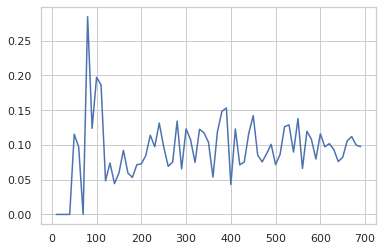

In [13]:
sns.lineplot(x=list(results.keys()), y=list(results.values()))

In [14]:
def reduce_to_most_meaningful(local_js, to=10):
    global_js = local_js.abs().mean(axis=0)
    global_js = global_js.sort_values(ascending=False)
    most_meaningful_coalitions = global_js.iloc[:to]
    return most_meaningful_coalitions.index

### Run calculation using new process

In [15]:
def calculate_using_new_process(X, y, k, value_f, num_iter = 300):
    n_features = frozenset(list(X.columns))
    n = len(n_features)
    coalitions_to_k = list(get_powerset_to_k(n_features, k))
    print(f"Starting calculation for k = {k} with {len(coalitions_to_k)} features")
    num_observations = len(y)
            
    baseline = explainer(X).base_values
    local_joint_shapleys = pd.DataFrame(index = X.index, columns=coalitions_to_k)

    for cln_n, cln in enumerate(coalitions_to_k):
        clear_output(wait=True)
        display(f"cln = {cln_n} / {len(coalitions_to_k)}")
        value_function = (
            lambda cln: get_estimate_for_coalition(cln, num_iter, X, value_f)
        )
        local_joint_shapleys.loc[:, [cln]] = value_function(cln).reshape(-1,1)

    clear_output(wait=True)
    display(f"Exporting data for k = {k} to csv")
    global_joint_shapleys = np.abs(local_joint_shapleys).mean(axis=0)
    return local_joint_shapleys, global_joint_shapleys

In [16]:
new_local, new_global = calculate_using_new_process(test_X, test_y, k, value_function)

'Exporting data for k = 3 to csv'

In [17]:
# export all local, global joint Shapleys
new_local.to_csv(f"local_{dataset_pathname}_all_js_k_{k}.csv")
new_global.to_csv(f"global_{dataset_pathname}_all_js_k_{k}.csv")

In [18]:
new_mm_local_js = new_local.loc[:, reduce_to_most_meaningful(new_local)]
new_mm_global_js = new_global.loc[reduce_to_most_meaningful(new_local)]

In [19]:
def show_strip_plot(local_js):
    stacked = local_js.stack().to_frame().rename(columns={0: "Joint Shapley"})
    stacked.loc[:, "Coalition"] = [ind[1] for ind in stacked.index]
    f, ax = plt.subplots()
    sns.despine(bottom=True, left=True)
    ax = sns.stripplot(
        x="Joint Shapley",
        y="Coalition",
        data=stacked, 
        dodge=True, alpha=.5, zorder=1)
    ax.xaxis.label.set_size(10)#set_xlabel("Coalition", fontsize=6)
    plt.show()

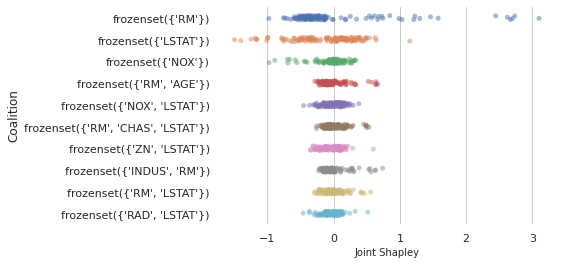

In [20]:
show_strip_plot(new_mm_local_js)

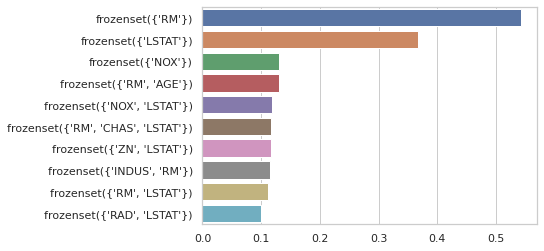

In [21]:
f, ax = plt.subplots()
sns.lineplot(bottom=True, left=True)
_ = sns.barplot(x=new_mm_global_js.values, y=new_mm_global_js.index)

In [22]:
new_mm_local_js.to_csv(f"local_{dataset_pathname}_js_k_{k}.csv")
new_mm_global_js.to_csv(f"globa_{dataset_pathname}_js_k_{k}.csv")